In [1]:
# analysis calcium imaging data, ratiometric data (eg. Alexa-594 and Fluo-5F)
# data was saved in a *.mat-file exported from MES
# structure of the *.mat-file is eg. 180315a -> dGR, G0R, red
# data was converted to a *.npy-file using the python script 'mat_2_npy_dGR_G0R_red_180315'
# date: 180315, AK

In [2]:
# import packages that are needed
import numpy as np
import scipy.io as sio
import pandas as pd 
import os
from os import listdir
from os.path import isfile, join
import csv
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib_scalebar.scalebar import ScaleBar
from IPython.display import display, HTML
from __future__ import division

In [3]:
# which experiment? ctrl or drug/mefloquine?
exp_cond = 'mefloquine'

In [4]:
# load data from this directory
from os.path import isfile, join
mypath = ('C:/Users/annek/Documents/Lab/olfactory_bulb_hung/calcium/npy_for_python/' + exp_cond + '/')

In [5]:
# only show folders in the npy_for_python directory
os.walk(mypath)
folders = [x[0] for x in os.walk(mypath)]
del folders[0]
n_exps = len(folders)

In [6]:
# save plots etc to this directories
# plotted timeline
save_plt_timeline = ('C:/Users/annek/Documents/Lab/olfactory_bulb_hung/calcium/results/' + exp_cond + '/')
# *.npy timeline
save_timeline = ('C:/Users/annek/Documents/Lab/olfactory_bulb_hung/calcium/results/' + exp_cond + '/')

In [7]:
# create a list were the results of all the spines and dendrites or segments go
list_sud_fr_tmln = []

# loop throuh the different folders belonging to the different cells
for i in range(0, n_exps):

    # name of the cell
    cell_name = folders[i][-7:]

    # directory dGR, G0R and red data
    dir_data = (mypath + cell_name + '/')

    # filenames dGR, G0R and red
    onlyfiles = [f for f in listdir(dir_data) if isfile(join(dir_data, f))]
    n_files = (len(onlyfiles))

    # import .npy-data from path
    for j in range(0, n_files):
        if "dGR" in onlyfiles[j]: 
            data_all_dGR = np.load(mypath + cell_name + '/' + onlyfiles[j])
        elif "G0R" in onlyfiles[j]: 
            data_all_G0R = np.load(mypath + cell_name + '/' + onlyfiles[j])
        elif "red" in onlyfiles[j]: 
            data_all_red = np.load(mypath + cell_name + '/' + onlyfiles[j])

    # length of the data
    len_data = len(data_all_dGR);

    # x: extract meta data for time calculation (only necessary for dGR)
    data_meta = [data_all_dGR[j][0] for j in range(0, len_data)]

    # y: extract dGR, G0R and red
    data_dGR = [data_all_dGR[j][1] for j in range(0, len_data)]
    data_G0R = [data_all_G0R[j][1] for j in range(0, len_data)]
    data_red = [data_all_red[j][1] for j in range(0, len_data)]

    # extract information about the number of spines and dendrites (sud) or segments measured
    data_sud = [data_all_dGR[j][2] for j in range(0, len_data)]
    n_sud = len(set(data_sud))

    # number of measurements
    n_meas = len(data_sud)
    n_meas_per_seg = data_sud.count(1)

    # parameters for all measurements
    points_sampled = [len(data_dGR[j]) for j in range(0, n_meas)]
    ipi_interval = [data_meta[j][1] for j in range(0, n_meas)]
    start_sampling = [data_meta[j][0] for j in range(0, n_meas)]
    sampling_interval = [((points_sampled[j] - 1) * ipi_interval[j]) for j in range(0, n_meas)]
    end_sampling = [(start_sampling[j] + sampling_interval[j]) for j in range(0, n_meas)]
    sr_kHz = [((points_sampled[j] - 1) / sampling_interval[j]) for j in range(0, n_meas)]

    # time calculation
    time = [(start_sampling[j] + ((range(0, (points_sampled[j]))) / sr_kHz[j])) for j in range(0, n_meas)]


    # determine the INTERVALS for detecting the calcium signal
    # red
    sign_red_pre = [(((460 - start_sampling[j]) / sampling_interval[j]) * points_sampled[j]) for j in range(0, n_meas)]
    sign_red_post = [(((600 - start_sampling[j]) / sampling_interval[j]) * points_sampled[j]) for j in range(0, n_meas)]
    # G0R
    sign_G0R_pre = [(((460 - start_sampling[j]) / sampling_interval[j]) * points_sampled[j]) for j in range(0, n_meas)]
    sign_G0R_post = [(((490 - start_sampling[j]) / sampling_interval[j]) * points_sampled[j]) for j in range(0, n_meas)]
    # dGR: DETERMINE SPECIFIC INTERVAL FOR THIS KIND OF DATA
    sign_pre_pre = [(((500 - start_sampling[j]) / sampling_interval[j]) * points_sampled[j]) for j in range(0, n_meas)]
    sign_post_post = [(((570 - start_sampling[j]) / sampling_interval[j]) * points_sampled[j]) for j in range(0, n_meas)]

    # mean over interval for bsln and signal (!!! PYTHON ROUNDS DIFFERENT THAN MATLAB!!!)
    sign_avg_red = [(np.mean(data_red[j][int(round(sign_red_pre[j])):int(round(sign_red_post[j]))])) for j in range(0, n_meas)]
    sign_avg_G0R = [(np.mean(data_G0R[j][int(round(sign_G0R_pre[j])):int(round(sign_G0R_post[j]))])) for j in range(0, n_meas)]
    sign_avg_dGR = [(np.mean(data_dGR[j][int(round(sign_pre_pre[j])):int(round(sign_post_post[j]))])) for j in range(0, n_meas)]
    sign_for_loop = [sign_avg_red, sign_avg_G0R, sign_avg_dGR]
    n_var_for_eval = len(sign_for_loop)

    
    # split spines and dendrites or segements
    for_list = []
    list_var = []
    list_all_sign = []
    for k in range(1, n_sud + 1):    
        for l in range(0, n_var_for_eval):
            for_list = [sign_for_loop[l][j] for j in range(0, n_meas) if data_sud[j] is k]
            list_var.append(for_list)
            del for_list
            for_list = []
        list_all_sign.append(list_var)
        del list_var
        list_var = [] 

    # work from now with a duplicate of the original array
    list_all_sign_final = list_all_sign
        
    # red: calculate mean bsln
    bsln_mean_red = [np.mean(np.mean(list_all_sign_final[k][0][0:5])) for k in range(0, n_sud)]
    # delete the measurements were red is lower than 80% (delete red, G0R and dGR)
    bsln_mean_red_80 = [bsln_mean_red[k] * 0.8  for k in range(0, n_sud)]
    
    for k in range(0, n_sud):
        for j in range(0, n_meas_per_seg):
            if list_all_sign_final[k][0][j] < bsln_mean_red_80[k]:
                list_all_sign_final[k][0][j] = 0
                list_all_sign_final[k][1][j] = 0
                list_all_sign_final[k][2][j] = 0

    # G0R: calculate mean bsln
    bsln_mean_G0R = []
    for k in range(0, n_sud):
        temp = np.asarray(list_all_sign[k][1][0:5])
        bsln_mean_G0R.append(temp[temp.nonzero()].mean())

    # delete the measurements were G0R is bigger than 120% (delete red, G0R and dGR)
    bsln_mean_G0R_120 = [bsln_mean_G0R[k] * 1.2  for k in range(0, n_sud)]

    for k in range(0, n_sud):
        for j in range(0, n_meas_per_seg):
            if list_all_sign_final[k][1][j] > bsln_mean_G0R_120[k]:
                list_all_sign_final[k][1][j] = 0
                list_all_sign_final[k][2][j] = 0  

    # remove all experiments were more than 2 G0R values in a row were too high
    # loop through G0R data and delete all downstream G0R values if 3 G0R values in a row were 120% higher than bsln
    # also delete the according values from the dGR list
    for k in range(0, n_sud):
        for j in range(0, n_meas_per_seg - 2):
            if list_all_sign_final[k][1][j] is 0 and list_all_sign_final[k][1][j + 1] is 0 and list_all_sign_final[k][1][j + 2] is 0:
                h= j
                n_left = n_meas_per_seg - j
                for h in range(h, n_meas_per_seg):
                    list_all_sign_final[k][1][h] = 0
                    list_all_sign_final[k][2][h] = 0
                break
            else: continue
        
    # dGR: extract traces for timeline
    list_sud_fr_tmln_temp = [list_all_sign_final[k][2] for k in range(0, n_sud)]
    list_sud_fr_tmln = list_sud_fr_tmln + list_sud_fr_tmln_temp
    

# print(list_sud_fr_tmln)

In [8]:
# remove spine and dendrite or segment if less 3 values are recorded as baseline
n_sud_rec = len(list_sud_fr_tmln)
list_sud_fr_tmln_2 = []
for i in range(0, n_sud_rec):
    if (np.count_nonzero(list_sud_fr_tmln[i][0:6])) > 3:
        list_sud_fr_tmln_2.append(list_sud_fr_tmln[i])
# print(list_sud_fr_tmln_2)

In [9]:
# normalization of the traces
# mean of the baseline
mean_bsln_all = []
n_sud_rec = len(list_sud_fr_tmln_2)
for i in range(0, n_sud_rec):
    temp = np.asarray(list_sud_fr_tmln_2[i][0:5])
    mean_bsln_all.append(temp[temp.nonzero()].mean())

# normalization
n_rec = [len(list_sud_fr_tmln_2[i]) for i in range(0, n_sud_rec)]
max_n_rec = max(n_rec)
list_sud_fr_tmln_2_norm = np.empty([n_sud_rec, max_n_rec])
# remove weird values that cam from the preallocation 
for i in range(0, n_sud_rec):
    for j in range(0, max_n_rec):
        list_sud_fr_tmln_2_norm[i][j] = 0

for i in range(0, n_sud_rec):
    n_rec = len(list_sud_fr_tmln_2[i])
    for j in range(0, n_rec):
            list_sud_fr_tmln_2_norm[i][j] = (list_sud_fr_tmln_2[i][j] / mean_bsln_all[i])


In [10]:
print(list_sud_fr_tmln_2_norm)

[[1.03506741 0.9958918  0.90305914 1.11635879 0.94962287 0.88860034
  0.92922751 0.74929846 0.621932   0.         0.         0.57710707
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [1.17942452 0.93418841 0.99848376 1.01319145 0.87471186 0.98445481
  0.89714333 0.85392721 1.03494686 0.         0.80520692 0.
  0.81030612 0.67318728 0.50975774 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.75453454 0.         0.         0.67351925 1.5719462  1.71386855
  1.23504582 1.55024869 1.54771982 1.14022907 1.2350773  1.20316117
  1.01257463 1.086687   0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.9599888  0.         1.05016312 1.08561572 0.90423237 1.0518525
  0.93802088 0.86093739 1.01226701 0.8684501  1.00400355 0.
  0.9

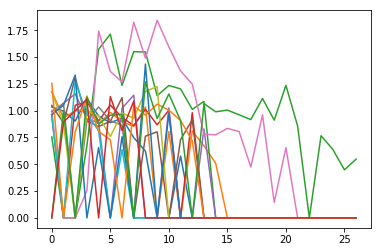

In [11]:
# timeline all single exps
n_sud_rec = len(list_sud_fr_tmln_2_norm)

# plot all single timelines in one plot
fig = plt.figure()
for i in range(0, n_sud_rec):
    plt.plot(list_sud_fr_tmln_2_norm[i])


In [12]:
# n-number
# determine n-number start
n_start = len(list_sud_fr_tmln_2_norm)
n_all = [n_start]

# n-number min 5-10
list_sud_fr_tmln_2_norm_5_10 = []
for j in range(0,n_start):
    if np.count_nonzero(list_sud_fr_tmln_2_norm[j][5:10] > 0):
        list_sud_fr_tmln_2_norm_5_10.append(list_sud_fr_tmln_2_norm[j][5:10])
n_5_10 = len(list_sud_fr_tmln_2_norm_5_10)
n_all.append(n_5_10)

# n-number min 10-15
list_sud_fr_tmln_2_norm_10_15 = []
for j in range(0,n_start):
    if np.count_nonzero(list_sud_fr_tmln_2_norm[j][10:15] > 0):
        list_sud_fr_tmln_2_norm_10_15.append(list_sud_fr_tmln_2_norm[j][10:15])
n_10_15 = len(list_sud_fr_tmln_2_norm_10_15)
n_all.append(n_10_15)

# n-number min 15-20
list_sud_fr_tmln_2_norm_15_20 = []
for j in range(0,n_start):
    if np.count_nonzero(list_sud_fr_tmln_2_norm[j][15:20] > 0):
        list_sud_fr_tmln_2_norm_15_20.append(list_sud_fr_tmln_2_norm[j][15:20])
n_15_20 = len(list_sud_fr_tmln_2_norm_15_20)
n_all.append(n_15_20)

# n-number min 20-25
list_sud_fr_tmln_2_norm_20_25 = []
for j in range(0,n_start):
    if np.count_nonzero(list_sud_fr_tmln_2_norm[j][20:25] > 0):
        list_sud_fr_tmln_2_norm_20_25.append(list_sud_fr_tmln_2_norm[j][20:25])
        print(np.count_nonzero(list_sud_fr_tmln_2_norm[j][20:25]))
n_20_25 = len(list_sud_fr_tmln_2_norm_20_25)
n_all.append(n_20_25)

# n-number min 25-30
list_sud_fr_tmln_2_norm_25_30 = []
for j in range(0,n_start):
    if np.count_nonzero(list_sud_fr_tmln_2_norm[j][25:30] > 0):
        list_sud_fr_tmln_2_norm_5_10.append(list_sud_fr_tmln_2_norm[j][25:30])
n_25_30 = len(list_sud_fr_tmln_2_norm_25_30)
n_all.append(n_25_30)

# save timeline as *.npy
np.save((save_timeline + exp_cond + '_n_numbers_all.npy'), n_all)

1
4


[1.0226069104965554, 0.9752141895932769, 1.0916717224268992, 0.9389133794449692, 0.9939130717750115, 1.0351706672500862, 0.9561415572739118, 1.1166683120321745, 1.131096512010854, 1.1241141228731555, 1.100162294137467, 0.9495720102455744, 0.9480175406957875, 0.8872005741231652, 0.758114839312387, 0.9200908969776869, 0.8839719832778345, 0.6955830136558574, 1.0376095654432498, 0.5286074450203105, 0.9455570314375158, 0.8559670875972258, 0, 0.7664935498214425, 0.6397587684340705, 0.44860065555815565, 0.5483898834703957]


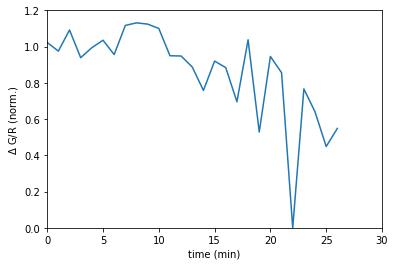

In [13]:
# timeline of the mean
# prerequisits
n_sud_rec = len(list_sud_fr_tmln_2_norm)
n_rec = [len(list_sud_fr_tmln_2_norm[i]) for i in range(0, n_sud_rec)]
# find the shortest recording (should be all the same length since they were add to a preallocated matrix)
min_n_rec = min(n_rec)

# rearrange list
rearr_list = []
new =[]
for j in range(0, min_n_rec):
    for k in range(0, n_sud_rec):
        new.append(list_sud_fr_tmln_2_norm[k][j])
    rearr_list.append(new)    
    del new
    new = []
        
# mean
n_all_timeline = len(rearr_list)
mean_all_for_timeline = []
for i in range(0, n_all_timeline):
    temp = np.asarray(rearr_list[i])
    if (np.count_nonzero(temp)) > 0:
        mean_all_for_timeline.append(temp[temp.nonzero()].mean())     
    else:
        mean_all_for_timeline.append(0)
print(mean_all_for_timeline)    
# time

# plot
fig = plt.figure()
plt.plot(mean_all_for_timeline)
plt.xlim(0, 30)
plt.ylim(0, 1.2)
plt.xlabel ('time (min)')
plt.ylabel ('$\Delta $ G/R (norm.)')

# save
# png
fig.savefig(save_plt_timeline + exp_cond + '_timeline_all.png')
# eps
plt.savefig((save_plt_timeline + exp_cond + '_timeline_all.eps'), format='eps', dpi=1000)
# plt.close()

In [14]:
# save timeline as *.npy
np.save((save_timeline + exp_cond + '_timeline_all.npy'), mean_all_for_timeline)